# MNIST com Pytorch

In [1]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

Populating the interactive namespace from numpy and matplotlib


## Separação dos Dados e Pré processamento

In [2]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [3]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [7]:
# One hidden Layer NN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = x.view((-1, 784))
        h = F.relu(self.fc(x))
        h = self.fc2(h)
        return F.log_softmax(h)    
    
    
model = Model()
if cuda:
    model.cuda() # CUDA!
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [8]:
EPOCHS = 5
losses = []

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().data[0])
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.cpu().data[0]), 
                end='')
    # Eval
    evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
    evaluate_y = Variable(test_loader.dataset.test_labels)
    if cuda:
        evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

    model.eval()
    output = model(evaluate_x)
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum()/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data[0],
        accuracy*100,
        end=''))

/home/abarbosa/miniconda3/envs/tera-jul2018/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/abarbosa/miniconda3/envs/tera-jul2018/lib/python3.6/site-packages/ipykernel/__main__.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/abarbosa/miniconda3/envs/tera-jul2018/lib/python3.6/site-packages/ipykernel/__main__.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


 Train Epoch: 1/5 [57664/60000 (96%)]	Loss: 0.095896

/home/abarbosa/miniconda3/envs/tera-jul2018/lib/python3.6/site-packages/ipykernel/__main__.py:55: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


 Train Epoch: 1/5 [60000/60000 (100%)]	Loss: 0.039269	 Test Accuracy: 0.0000%
 Train Epoch: 2/5 [60000/60000 (100%)]	Loss: 0.045295	 Test Accuracy: 0.0000%
 Train Epoch: 3/5 [60000/60000 (100%)]	Loss: 0.005965	 Test Accuracy: 0.0000%
 Train Epoch: 4/5 [60000/60000 (100%)]	Loss: 0.035064	 Test Accuracy: 0.0000%
 Train Epoch: 5/5 [60000/60000 (100%)]	Loss: 0.009668	 Test Accuracy: 0.0000%


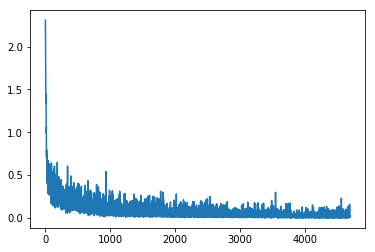

In [9]:
plot(losses)

## Métricas

In [10]:
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.test_labels)
if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

model.eval()
output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum()/d.size()[0]

print('Accuracy:', accuracy*100)

Accuracy: tensor(0)


/home/abarbosa/miniconda3/envs/tera-jul2018/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Keras vs Tensorflow vs Pytorch

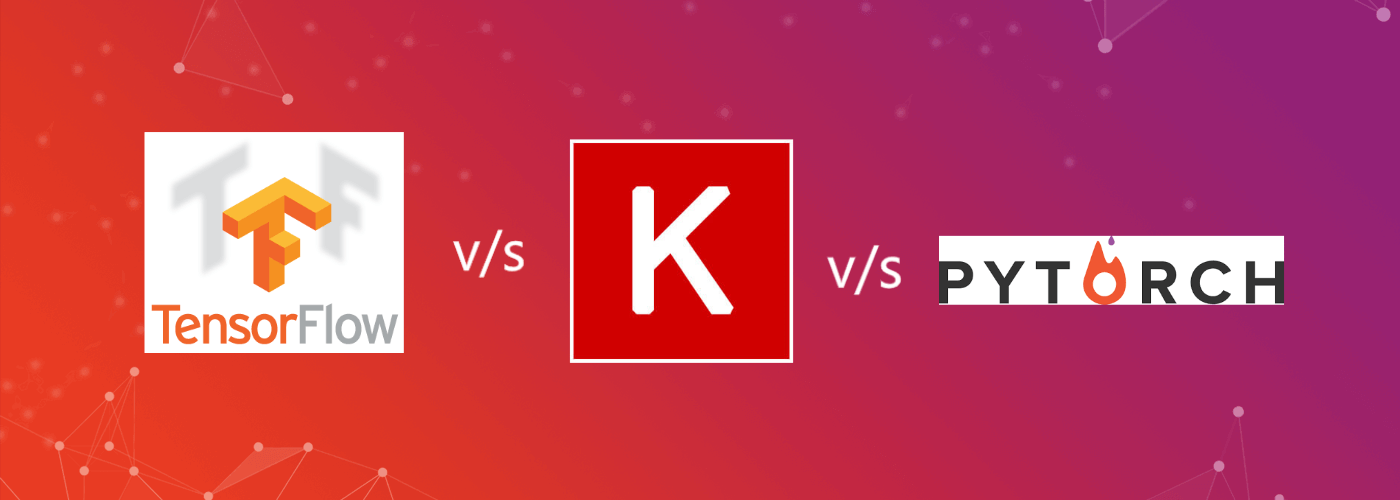

## Tensorflow


1. Engajamento da Comunidade

2. Flexibilidade absurda ! A necessidade de definir sempre o grafo de computação garante maior modularidade

3. Multiplataforma (CPU, GPU, celular)

4. Performance (O grafo de computação, por ser mais dinâmico, permite que tiremos proveito máximo do Hardware)

## Pytorch

O Tensorflow é construído em cima de um conceito chamado grafo computacional estático. Em outras palavras, você define tudo antes e depois roda.

Já o Pytorch usa o conceito de grafo de computação dinâmico. Tê permite definir as coisas em quanto você roda. 

Você abre mão de um pouco de desempenho para ter uma facilidade maior na hora de codar e/ou debugar.

Qual é o melhor?

## Keras

O Keras foi desenvolvido para que pudessemos ter uma prototipação rápida. Ela é tida mais como uma lib "front-end" já que toda a computação pesada é realizada pelo Tensorflow. Na prática, ela permite uma prototipação e experimentação de redes muito mais rápida que o tensorflow, além de promover uma API bem mais alto nível.